# Table of Contents
 <p><div class="lev1 toc-item"><a href="#LSTM-Lecture" data-toc-modified-id="LSTM-Lecture-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LSTM Lecture</a></div><div class="lev1 toc-item"><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></div><div class="lev1 toc-item"><a href="#Many-to-One" data-toc-modified-id="Many-to-One-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Many to One</a></div><div class="lev2 toc-item"><a href="#Reshaping-the-Data-1-(X-:-Multiple,-Y-:-1)" data-toc-modified-id="Reshaping-the-Data-1-(X-:-Multiple,-Y-:-1)-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Reshaping the Data 1 (X : Multiple, Y : 1)</a></div><div class="lev3 toc-item"><a href="#Dimension" data-toc-modified-id="Dimension-311"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Dimension</a></div><div class="lev3 toc-item"><a href="#Assignment" data-toc-modified-id="Assignment-312"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Assignment</a></div><div class="lev3 toc-item"><a href="#Reshaping-:-1D-to-2D-(for-MinMaxScaler)" data-toc-modified-id="Reshaping-:-1D-to-2D-(for-MinMaxScaler)-313"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Reshaping : 1D to 2D (for <code>MinMaxScaler</code>)</a></div><div class="lev3 toc-item"><a href="#Scaling-:-MinMax,-0-~-1" data-toc-modified-id="Scaling-:-MinMax,-0-~-1-314"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Scaling : <code>MinMax</code>, 0 ~ 1</a></div><div class="lev3 toc-item"><a href="#Reshaping-X:-2D-to-3D,-(Samples,-Timestep-Sequence,-Features)" data-toc-modified-id="Reshaping-X:-2D-to-3D,-(Samples,-Timestep-Sequence,-Features)-315"><span class="toc-item-num">3.1.5&nbsp;&nbsp;</span>Reshaping <code>X</code>: 2D to 3D, (Samples, Timestep-Sequence, Features)</a></div><div class="lev3 toc-item"><a href="#Splitting-:-Train-&amp;-Test" data-toc-modified-id="Splitting-:-Train-&amp;-Test-316"><span class="toc-item-num">3.1.6&nbsp;&nbsp;</span>Splitting : Train &amp; Test</a></div><div class="lev3 toc-item"><a href="#Callback-Objects" data-toc-modified-id="Callback-Objects-317"><span class="toc-item-num">3.1.7&nbsp;&nbsp;</span>Callback Objects</a></div><div class="lev2 toc-item"><a href="#LSTM-Model-:-Single-Output" data-toc-modified-id="LSTM-Model-:-Single-Output-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LSTM Model : Single Output</a></div><div class="lev3 toc-item"><a href="#Modeling" data-toc-modified-id="Modeling-321"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Modeling</a></div><div class="lev3 toc-item"><a href="#Training" data-toc-modified-id="Training-322"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Training</a></div><div class="lev3 toc-item"><a href="#Scoring" data-toc-modified-id="Scoring-323"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Scoring</a></div><div class="lev3 toc-item"><a href="#Testing" data-toc-modified-id="Testing-324"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Testing</a></div>

# LSTM Lecture

!['lstm'](lstm.jpg)

In Recurrent Neural Networks, we are quickly confronted to the so-called __gradient vanishing problem__:

In machine learning, __the vanishing gradient problem__ is a difficulty found in training artificial neural networks with gradient-based learning methods and backpropagation.  
In such methods, each of the neural network’s weights receives an update proportional to the gradient of the error function with respect to the current weight in each iteration of training.   
_Traditional activation functions such as the hyperbolic tangent function have gradients in the range `(−1,1)` or `(0,1)`_, and backpropagation computes gradients by the chain rule.  
This has the effect of multiplying n of these small numbers to compute gradients of the “front” layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n and the front layers train very slowly.

One solution is __to consider *adding the updates* instead of multiplying them__, and this is exactly what the LSTM does. The state of every cell is updated in an additive way (Equation 9) such that the gradient hardly vanishes.

![lstm](keras_stateful_lstm_2.png)
![lstm](lstm_basic.png)
![lstm](lstm_module.jpg)
![](LSTM.png)

In [1]:
import os
import math
import datetime as dt
import itertools as it
from glob import glob
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Flatten
from keras.callbacks import Callback, LambdaCallback

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.layers import TimeDistributed, Embedding, RepeatVector, Permute, Lambda
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.layers import Input, Reshape, dot, multiply

# Data

In [3]:
data = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
data = read_csv('PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
data.drop('No', axis=1, inplace=True)
# manually specify column names
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
data.index.name = 'date'
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]
# summarize first 5 rows
print(data.head(5))
# save to file
data.to_csv('pollution.csv')
data

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


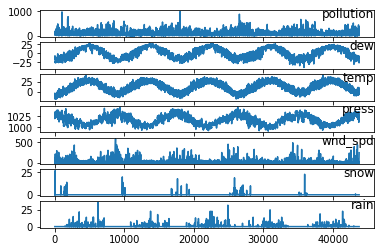

In [4]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [5]:
from pandas import DataFrame, concat
from sklearn.preprocessing import LabelEncoder

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [7]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print('Train_X\t: %s\nTrain_Y\t: %s\nTest_X\t: %s\nTest_Y\t: %s\n' % 
      (train_X.shape, train_Y.shape, test_X.shape, test_Y.shape))

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [8]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y,
                    epochs=100,
                    batch_size=64,
                    validation_split=.2,
                    #validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 18,753
Trainable params: 18,753
Non-trainable params: 0
_________________________________________________________________
Train on 7008 samples, validate on 1752 samples
Epoch 1/100
 - 1s - loss: 0.0563 - val_loss: 0.0713
Epoch 2/100
 - 0s - loss: 0.0405 - val_loss: 0.0496
Epoch 3/100
 - 0s - loss: 0.0275 - val_loss: 0.0363
Epoch 4/100
 - 0s - loss: 0.0198 - val_loss: 0.0198
Epoch 5/100
 - 0s - loss: 0.0167 - val_loss: 0.0168
Epoch 6/100
 - 0s - loss: 0.0156 - val_loss: 0.0153
Epoch 7/100
 - 0s - loss: 0.0152 - val_loss: 0.0150
Epoch 8/100
 - 0s - loss: 0.0148 - val_loss: 0.0148
Epoch 9/100
 - 0s - loss: 0.0148 - val_loss: 0.0153
Epoch 10/100
 - 0s

In [9]:
model.input_shape

(None, 1, 8)

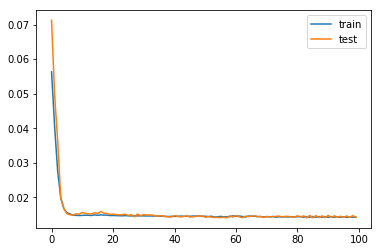

In [10]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
from numpy import concatenate, sqrt

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.578


In [12]:
inv_y

array([ 31.,  20.,  19., ...,  10.,   8.,  12.], dtype=float32)

In [13]:
inv_yhat

array([ 38.78778839,  32.81549835,  21.99749947, ...,  13.15476322,
        13.13411522,  11.38121605], dtype=float32)

In [14]:
print('Real: %s, Predict: %s' % (inv_y[-1], inv_yhat[-1]))

Real: 12.0, Predict: 11.3812


# Many to One

!['lstm_many_to_one'](lstm_many_to_one.jpg)

## Reshaping the Data 1 (X : Multiple, Y : 1)

### Dimension

In [15]:
xcol = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
ycol = ['pollution']
xfeature = len(xcol)
yfeature = len(ycol)
look_back = timestep = xlen = 5
foresight = 1
ylen = 1

### Assignment

In [16]:
encoder = LabelEncoder()

data.iloc[:, 4] = encoder.fit_transform(data.iloc[:, 4])

In [17]:
data_X_1d = data.loc[:, xcol].values.astype('float32')
print(data_X_1d.shape)
data_X_1d

(43800, 8)


array([[ 129.        ,  -16.        ,   -4.        , ...,    1.78999996,
           0.        ,    0.        ],
       [ 148.        ,  -15.        ,   -4.        , ...,    2.68000007,
           0.        ,    0.        ],
       [ 159.        ,  -11.        ,   -5.        , ...,    3.56999993,
           0.        ,    0.        ],
       ..., 
       [  10.        ,  -22.        ,   -3.        , ...,  242.69999695,
           0.        ,    0.        ],
       [   8.        ,  -22.        ,   -4.        , ...,  246.72000122,
           0.        ,    0.        ],
       [  12.        ,  -21.        ,   -3.        , ...,  249.8500061 ,
           0.        ,    0.        ]], dtype=float32)

In [18]:
data_Y_1d = data.loc[:, ycol].values.astype('float32')
print(data_Y_1d.shape)
data_Y_1d

(43800, 1)


array([[ 129.],
       [ 148.],
       [ 159.],
       ..., 
       [  10.],
       [   8.],
       [  12.]], dtype=float32)

### Reshaping : 1D to 2D (for `MinMaxScaler`)

In [19]:
data_X_1d.shape

(43800, 8)

In [20]:
data_X_2d = data_X_1d.reshape(-1, xfeature)
print(data_X_2d.shape)
data_X_2d

(43800, 8)


array([[ 129.        ,  -16.        ,   -4.        , ...,    1.78999996,
           0.        ,    0.        ],
       [ 148.        ,  -15.        ,   -4.        , ...,    2.68000007,
           0.        ,    0.        ],
       [ 159.        ,  -11.        ,   -5.        , ...,    3.56999993,
           0.        ,    0.        ],
       ..., 
       [  10.        ,  -22.        ,   -3.        , ...,  242.69999695,
           0.        ,    0.        ],
       [   8.        ,  -22.        ,   -4.        , ...,  246.72000122,
           0.        ,    0.        ],
       [  12.        ,  -21.        ,   -3.        , ...,  249.8500061 ,
           0.        ,    0.        ]], dtype=float32)

In [21]:
data_Y_2d = data_Y_1d.reshape(-1, yfeature)
print(data_Y_2d.shape)
data_Y_2d

(43800, 1)


array([[ 129.],
       [ 148.],
       [ 159.],
       ..., 
       [  10.],
       [   8.],
       [  12.]], dtype=float32)

### Scaling : `MinMax`, 0 ~ 1

In [22]:
scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))

scaled_X = scalerX.fit_transform(data_X_2d)
scaled_Y = scalerY.fit_transform(data_Y_2d)

print(scaled_X)
print(scaled_Y)

[[ 0.12977867  0.35294122  0.24590163 ...,  0.00229001  0.          0.        ]
 [ 0.14889336  0.36764708  0.24590163 ...,  0.00381099  0.          0.        ]
 [ 0.15995975  0.42647061  0.22950819 ...,  0.00533197  0.          0.        ]
 ..., 
 [ 0.01006036  0.2647059   0.26229507 ...,  0.41399646  0.          0.        ]
 [ 0.00804829  0.2647059   0.24590163 ...,  0.42086649  0.          0.        ]
 [ 0.01207243  0.27941179  0.26229507 ...,  0.42621556  0.          0.        ]]
[[ 0.12977867]
 [ 0.14889336]
 [ 0.15995975]
 ..., 
 [ 0.01006036]
 [ 0.00804829]
 [ 0.01207243]]


### Reshaping `X`: 2D to 3D, (Samples, Timestep-Sequence, Features)

In [23]:
len(scaled_X) - xlen - foresight - ylen

43793

In [24]:
seq_X = np.array([scaled_X[i:i+xlen] for i in range(0, len(scaled_X) - xlen - (foresight - 1) - (ylen - 1))])
print('X Shape:', seq_X.shape)
seq_X

X Shape: (43795, 5, 8)


array([[[ 0.12977867,  0.35294122,  0.24590163, ...,  0.00229001,
          0.        ,  0.        ],
        [ 0.14889336,  0.36764708,  0.24590163, ...,  0.00381099,
          0.        ,  0.        ],
        [ 0.15995975,  0.42647061,  0.22950819, ...,  0.00533197,
          0.        ,  0.        ],
        [ 0.18209255,  0.48529413,  0.22950819, ...,  0.00839101,
          0.03703704,  0.        ],
        [ 0.13883299,  0.48529413,  0.22950819, ...,  0.00991199,
          0.07407407,  0.        ]],

       [[ 0.14889336,  0.36764708,  0.24590163, ...,  0.00381099,
          0.        ,  0.        ],
        [ 0.15995975,  0.42647061,  0.22950819, ...,  0.00533197,
          0.        ,  0.        ],
        [ 0.18209255,  0.48529413,  0.22950819, ...,  0.00839101,
          0.03703704,  0.        ],
        [ 0.13883299,  0.48529413,  0.22950819, ...,  0.00991199,
          0.07407407,  0.        ],
        [ 0.10965794,  0.48529413,  0.21311474, ...,  0.01143297,
          0.11

In [25]:
seq_Y = np.array([scaled_Y[i:i+ylen][0] for i in range(xlen + (foresight - 1), len(scaled_Y))])
print('Y Shape:', seq_Y.shape)
seq_Y

Y Shape: (43795, 1)


array([[ 0.10965794],
       [ 0.1056338 ],
       [ 0.12474848],
       ..., 
       [ 0.01006036],
       [ 0.00804829],
       [ 0.01207243]], dtype=float32)

### Splitting : Train & Test

In [26]:
test_size = .3

(train_X, test_X,
 train_Y, test_Y)  = train_test_split(seq_X, seq_Y,
                                      test_size=test_size,
                                      shuffle=False,
                                      random_state=99)

print('Train_X\t: %s\nTrain_Y\t: %s\nTest_X\t: %s\nTest_Y\t: %s\n' % 
      (train_X.shape, train_Y.shape, test_X.shape, test_Y.shape))

Train_X	: (30656, 5, 8)
Train_Y	: (30656, 1)
Test_X	: (13139, 5, 8)
Test_Y	: (13139, 1)



### Callback Objects

In [27]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.weights = []

#    def on_batch_begin(self, batch, logs={}):
#        self.weights.append([{'begin_' + layer.name: layer.get_weights()} for layer in model.layers])

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.weights.append([{'end_' + layer.name: layer.get_weights()} for layer in model.layers])

history = LossHistory()

print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: pprint(model.layers[0].get_weights()))

## LSTM Model : Single Output

### Modeling

In [28]:
data_len, timestepX, ndimX = train_X.shape
#_, timestepY, ndimY = trainY.shape
_, ndimY = train_Y.shape

HIDDEN_SIZE = 16

# simple lstm network learning
model = Sequential()
"""
2D: (batch_size, units)
3D: (batch_size, timesteps, input_dim)
"""
model.add(LSTM(HIDDEN_SIZE,  # Network Node
               input_shape=(timestepX, ndimX),  # Time-step, Feature Number
               #dropout=.3,  # Drop-Out Ratio; Among the Input
               #recurrent_dropout=.3,  # Recurrent Drop-out Ratio; Among the Recurrent Network
               #return_sequences=False,  # If LSTM Returns the sequence;the same dimension of the input.
               #kernel_initializer=keras.initializers.Zeros(),
               #recurrent_initializer='zeros',
               #bias_initializer='zeros',
               #use_bias=True
              ))
model.add(Dense(ndimY,  # Network Node
                #input_shape=(ylen, ndimX),  # Time-step, Feature Number
                #activation='linear',
                #kernel_initializer='zeros',
                #bias_initializer='zeros',
               ))

model.compile(loss='mae', optimizer='adam')

pprint(model.weights)
print(model.input_shape)
model.summary()

[<tf.Variable 'lstm_2/kernel:0' shape=(8, 64) dtype=float32_ref>,
 <tf.Variable 'lstm_2/recurrent_kernel:0' shape=(16, 64) dtype=float32_ref>,
 <tf.Variable 'lstm_2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(16, 1) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32_ref>]
(None, 5, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________


In [29]:
print(model.input_shape)

(None, 5, 8)


### Training

In [30]:
EPOCH_NUM = 300
BATCH_SIZE = 64

fitted = model.fit(train_X, train_Y,
                   epochs=EPOCH_NUM,     # How many times to run back_propagation
                   batch_size=BATCH_SIZE,  # How many data to deal with at one epoch
                   verbose=1,       # 1: progress bar, 2: one line per epoch
                   validation_split=.2,
                   #validation_data=(testX, testY),  # Validation set
                   shuffle=False,
                   callbacks=[history])

Train on 24524 samples, validate on 6132 samples
Epoch 1/300
24524/24524 [==============================] - 2s 87us/step - loss: 0.0338 - val_loss: 0.0257
Epoch 2/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0203 - val_loss: 0.0226
Epoch 3/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0186 - val_loss: 0.0208
Epoch 4/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0168 - val_loss: 0.0213
Epoch 5/300
24524/24524 [==============================] - 2s 80us/step - loss: 0.0155 - val_loss: 0.0190
Epoch 6/300
24524/24524 [==============================] - 2s 80us/step - loss: 0.0149 - val_loss: 0.0180
Epoch 7/300
24524/24524 [==============================] - 2s 81us/step - loss: 0.0145 - val_loss: 0.0166
Epoch 8/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0141 - val_loss: 0.0162
Epoch 9/300
24524/24524 [==============================] - 2s 80us/step - loss: 0.0139 - val_loss: 0.01

24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0156
Epoch 154/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0156
Epoch 155/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0128 - val_loss: 0.0157
Epoch 156/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0156
Epoch 157/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0128 - val_loss: 0.0156
Epoch 158/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0156
Epoch 159/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0156
Epoch 160/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0156
Epoch 161/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0157
Epoch 162/300
24524/24524 [===============

Epoch 229/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0157
Epoch 230/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0158
Epoch 231/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0158
Epoch 232/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0160
Epoch 233/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0159
Epoch 234/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0159
Epoch 235/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0156
Epoch 236/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0127 - val_loss: 0.0159
Epoch 237/300
24524/24524 [==============================] - 2s 79us/step - loss: 0.0126 - val_loss: 0.0156
Epoch 238/300
24524/24524 [=

In [31]:
pprint(history.losses[:3])
pprint(history.weights[:3])

[0.18334484, 0.076655127, 0.14146312]
[[{'end_lstm_2': [array([[  8.45291167e-02,  -1.38753587e-02,   1.35443285e-01,
          1.87175408e-01,  -3.26788635e-03,  -2.56988943e-01,
          2.14865252e-01,  -4.97867092e-02,  -1.10149883e-01,
         -2.87254341e-04,   1.36951715e-01,  -1.04082219e-01,
          2.37383440e-01,  -8.70037973e-02,  -1.24991432e-01,
          1.56815991e-01,   3.30224223e-02,  -1.73776612e-01,
         -9.60739404e-02,   5.20283543e-02,  -1.86261311e-01,
         -3.33466940e-02,   9.29693729e-02,   1.56575844e-01,
          1.88969344e-01,  -2.49689788e-01,   1.65411979e-01,
          6.64016008e-02,   2.58740604e-01,   4.99444902e-02,
          2.02056170e-01,   2.38705397e-01,   1.58963323e-01,
         -1.92576155e-01,  -9.24885496e-02,  -4.73724082e-02,
          2.05910176e-01,  -2.34887287e-01,  -2.54458934e-01,
         -2.76200086e-01,   6.75333142e-02,  -3.18728350e-02,
          2.49737397e-01,  -1.49152085e-01,   1.24835901e-01,
          1.28

In [32]:
model.layers[0].__dict__

{'_built': True,
 '_initial_weights': None,
 '_losses': [],
 '_non_trainable_weights': [],
 '_num_constants': None,
 '_per_input_losses': {},
 '_per_input_updates': {},
 '_states': None,
 '_trainable_weights': [],
 '_updates': [],
 'activity_regularizer': None,
 'batch_input_shape': (None, 5, 8),
 'cell': <keras.layers.recurrent.LSTMCell at 0x7f28a5494fd0>,
 'constants_spec': None,
 'dtype': 'float32',
 'go_backwards': False,
 'inbound_nodes': [<keras.engine.topology.Node at 0x7f28a5c51ef0>],
 'input_spec': [<keras.engine.topology.InputSpec at 0x7f28a5494668>],
 'name': 'lstm_2',
 'outbound_nodes': [<keras.engine.topology.Node at 0x7f28a3183da0>],
 'return_sequences': False,
 'return_state': False,
 'state_spec': [<keras.engine.topology.InputSpec at 0x7f28a314a4e0>,
 'stateful': False,
 'supports_masking': True,
 'trainable': True,
 'unroll': False}

In [33]:
pprint(fitted.history)
pprint(fitted.params)

{'loss': [0.033779236167071403,
          0.020337651275758196,
          0.018585273281743565,
          0.016788585761495455,
          0.015512988904299365,
          0.014880644734459743,
          0.014457475617916835,
          0.014052360878670669,
          0.013862090543473919,
          0.01367403797761561,
          0.013674114581517714,
          0.01360940321510689,
          0.013572111293488801,
          0.013568208657862544,
          0.013552160903840621,
          0.013526221296136773,
          0.013509968294478166,
          0.013588693705050947,
          0.013552341040553773,
          0.013526971474571828,
          0.013551200544539078,
          0.013481090156398829,
          0.01345430823418799,
          0.013449736921105468,
          0.013432743517544331,
          0.013411532365644839,
          0.013373456222721111,
          0.013333336712801326,
          0.013353437148222933,
          0.013318323605752967,
          0.013354707857139094,
          0

### Scoring

/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


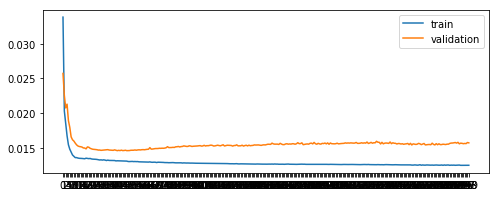

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
ax.plot(fitted.history['loss'], label='train')
if 'val_loss' in fitted.history.keys():
    ax.plot(fitted.history['val_loss'], label='validation')
ax.legend()
ax.set_xticks(np.arange(EPOCH_NUM))
fig.show()

In [35]:
train_Y_real = scalerY.inverse_transform(train_Y)
train_Y_hat = scalerY.inverse_transform(fitted.model.predict(train_X))

train_score = np.sqrt(mean_squared_error(train_Y_real, train_Y_hat))
print('Training Score: %.3f RMSE' % train_score)

Training Score: 27.554 RMSE


### Testing

In [36]:
test_Y_real = scalerY.inverse_transform(test_Y)
test_Y_hat = scalerY.inverse_transform(fitted.model.predict(test_X))

test_score = np.sqrt(mean_squared_error(test_Y_real, test_Y_hat))
print('Test Score: %.3f RMSE' % test_score)
print('Real\t:\n %s,\nPredict\t:\n %s' % (test_Y_real[-1][0], test_Y_hat[-1][0]))

Test Score: 23.322 RMSE
Real	:
 12.0,
Predict	:
 9.59765


Done.